# Transformers - Attention is All You Need
Welcome to the captivating world of Transformers in Natural Language Processing (NLP)! In recent years, Transformers have emerged as a groundbreaking paradigm in NLP, revolutionizing how we comprehend and process language. Unlike older architectures such as LSTMs (Long Short-Term Memory) and CNNs (Convolutional Neural Networks), Transformers leverage self-attention mechanisms, enabling them to capture long-range dependencies more effectively and allowing for parallelization of computations. The seminal paper ['Attention Is All You Need'](https://arxiv.org/abs/1706.03762) introduced the Transformer model, showcasing its prowess in various language tasks and laying the foundation for its widespread adoption. This Jupyter notebook is designed to unravel the intricacies of Transformers, highlighting their architectural nuances, contrasting them with traditional models, and demonstrating their applications across diverse NLP domains! (And in case you were wondering - yes, a certain transformer model created this text :D)

We will stick very closely to the implementation presented in the paper to build our own translation model! There is no need to read it though, you can find the necessary sections of the paper before each task, together with some explanations. If you did not work on exercise 11, we would really advise you to do that first, since we will pick up on many of those topics!

Alright - let's do this!

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [254]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_11) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n"

## Setup

In [256]:
from exercise_code.util import notebook_util as util
from exercise_code.network import *
from exercise_code.tests import *
from exercise_code.trainer import MPS_AVAILABLE
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

root_path = os.path.dirname(os.path.abspath(os.getcwd()))
model_path = os.path.join(os.getcwd(), 'models')
submission_path = os.path.join(os.getcwd(), 'submission_files')
pretrained_model_path = os.path.join(model_path, 'pretrainedModels')
dataset_path = os.path.join(root_path, 'datasets', 'transformerDatasets')

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Overview

<!-- <img src="images/Transformer-Transformer.drawio.png" width="2500"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Transformer.drawio.png"  width="2500">




The model consists of two bigger building blocks, the encoder and the decoder. The encoder processes the input to our model. In our translation model, this input would be the sentence in the source language. The decoder part iteratively produces an output sequence. As an input it takes the already predicted words and given that sequence and the encoder input, it produces an output sequence as follows:

| Encoder Input                       | Decoder Input                                      | Decoder Output                                   |
|-------------------------------------|----------------------------------------------------|--------------------------------------------------|
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>"]                                       | ["Hallo"]                                        |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo"]                              | ["Hallo", "wie"]                                 |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie"]                       | ["Hallo", "wie", "geht's"]                       |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie", "geht's"]             | ["Hallo", "wie", "geht's", "dir"]                |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie", "geht's", "dir"]      | ["Hallo", "wie", "geht's", "dir", "?"]           |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie", "geht's", "dir", "?"] | ["Hallo", "wie", "geht's", "dir", "?", "\<end>"] |

And the predicted end token breaks the loop.

<div class="alert alert-warning">
    <h3>WARNING: Task Implementation</h3>
    <p>Throughout this notebook you will as always have to complete several tasks to complete the individual modules! Please be aware though, that some Modules may have several tasks that have to be completed, but please <strong>only</strong> concentrate on the <strong>current task</strong> and the <strong>corresponding hints</strong> (if there are any;). In other words, if you are working on Task 1, and there is also Task 4 in the TODOs of that Module, you don't have to work on it at this moment! <br>
    Also, if we mention any specific pytorch modules in the task description or hints, you <strong>are allowed to use them!</strong> With that said, let's work on your first task!
    </p>
</div>

# Cross Attention vs Self Attention

You might have noticed, that we are always talking about inputs to an attention mechanism and the context we want to compare it to. If we use the terminology from the paper, our inputs form the query of our attention mechanism, and the context form the key - value pairs! 

## Cross Attention
Cross-Attention might be the easier idea to understand. We use two different sources for the input and context! In the transformer model, this type of attention will be used in the decoder, that way we can contextualize our output with the actual input to our model. 

Let's say you ask the model a question like "Hello, how are you?". This will be processed by the encoder and it will give us some output. Next, the decoder will start to produce its output token by token, and at each step, the output should obviously depend on our initial question! We can achieve this by using cross attention, where the inputs to the mechanism come from the decoder itself, and the context comes from the encoder. It is trying to give context from our input to its output - something we definetly want to have!

## Self Attention
In Self-Attention, the input and the context source are the same! That means, every word in a sequence is attending to all words in the same sequence, or in other words - the sentence is attending to itself. This form is used in both the encoder and decoder, and is used to process their inputs to gain a "deeper" understanding of the inputs by giving them context.

<!-- <img src="images/Transformer-Self Cross Attention.drawio.png" width=2000> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Self Cross Attention.drawio.png" width=2000>


## Encoder Block

The encoder side of the transformer processes the input to the model. If your model is trained on translating sentences, the input will be the sentence in the source language. 

Each Block consists of 

1. **multi-head self-attention layer**
2. **residual connection**
3. **layer normalization**
4. **feed forward network**
5. **residual connection**
6. **layer normalization**

We use layer normalization instead of batch normalization to get similar advantages of improving training stability while decoupling it from the batch size. (Remember, in batch normalization we normalize over an entire batch, while in layer normalization we normalize across over all inputs of a single sample!)

The feed forward network is applied to each token embedding separately with follwing architecture: 

$FFN(x) = RELU(xW_1 + b_1) \cdot W_2 + b_2$,  where

$shape(W_1) = (d_{model},\, d_{ff})$ </br>
$shape(W_2) = (d_{ff},\, d_{model})$

After this, another residual connection followed by a layer normalization is added.

One intuitive way to think about this $MultiHead \rightarrow FFN$ structure of the encoder block is that the attention mechanism is used to "look around" in the input sequence and the feed forward network is used to process the information and transform it into a more useful representation.

<!-- <img src="images/Transformer-Encoder Block.drawio.png" width="1300"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Encoder Block.drawio.png" width=1300>


<div class="alert alert-info">
    <h3>Task 3: Implement</h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>FeedForwardNeuralNetwork</code> class in <code>exercise_code/network/nn.py</code>.
    </p>
</div>

In [264]:
_ = test_task_3()


####### Testing Started #######

Test TestLinear1: passed!
Test TestLinear1Bias: passed!
Test TestLinear2: passed!
Test TestLinear2Bias: passed!
Test TestParameterCount: passed!

####### Testing Finished #######
Test TestTask3: passed! -->  Tests passed: 5/5
Score: 100/100


<div class ="alert alert-info">
    <h3>Task 4: Implement </h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>EncoderBlock</code> class in <code>exercise_code/network/encoder_block.py</code>.
    </p>
</div>

In [266]:
_ = test_task_4()


####### Testing Started #######

Test EncoderBlockOutputShapeTest: passed!
Test EncoderBlockOutputNorm: passed!
Test EncoderBlockParameterCountTest: passed!
Test EncoderBlockValueTest: passed!

####### Testing Finished #######
Test TestTask4: passed! -->  Tests passed: 4/4
Score: 100/100


## Encoder Stack

The only part left on the encoder side is to stack multiple blocks together!

<!-- <img src="images/Transformer-Encoder.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Encoder.drawio.png" width=1000>


<div class="alert alert-info">
    <h3>Task 5: Check Code</h3>
    <p>Check the <code>__init__()</code> method and the <code>forward()</code> method of the <code>Encoder</code> class in <code>exercise_code/network/encoder.py</code>.
    </p>
</div>

In [269]:
_ = test_task_5()


####### Testing Started #######

Test EncoderOutputShapeTest: passed!
Test EncoderParameterCountTest: passed!

####### Testing Finished #######
Test TestTask5: passed! -->  Tests passed: 2/2
Score: 100/100


# Decoder
The job of the decoder is basically to produce an output given an input and the previous outputs (if available). Those previous outputs are also the input to the decoder! We have actually already seen most of the relevant parts of the decoder in the encoder, there is only one major addition: Causal attention!




## Causal Attention

Previous language models based on RNN have one large draw back: during training, the model has to iteratively go through the entire sequence to predict the next word. Transformer models on the other hand can do this in parallel!

So instead of something like this:

|                    | Iteration 1                        | Iteration 2                        | Iteration 3                        |  
|--------------------|------------------------------------|------------------------------------|------------------------------------|
| **Encoder Input**  | ["Hello" ,"how", "are", "you", "?"]| ["Hello" ,"how", "are", "you", "?"]| ["Hello" ,"how", "are", "you", "?"]|
| **Decoder Input**  | ["\<start>"]                       | ["\<start>", "Nicht"]              | ["\<start>", "Nicht", "sehr"]      | 
| **Decoder Output** | ["Nicht"]                          | ["Nicht", "sehr"]                  | ["Nicht", "sehr", "effektiv"]      | 
| **Compare to**     | ["Hallo"]                          | ["Hallo", "wie"]                   | ["Hallo", "wie", "geht's"]         | 


and so on we want to do this in one pass, where we give the model the correct sentence as the decoder input. It is shifted right, since the model should predict the first token, given the \<start> token.

|                    | Iteration 1                                        |
|--------------------|----------------------------------------------------|
| **Encoder Input**  | ["Hello" ,"how", "are", "you", "?"]                |
| **Decoder Input**  | ["\<start>", "Hallo", "wie", "geht's", "dir", "?"] | 
| **Decoder Output** | ["Hallo", "wie", "geht's", "dir", "?", "\<end>"]   | 
| **Compare to**     | ["Hallo", "wie", "geht's", "dir", "?", "\<end>"]   | 


Problem is, our model could theoretically learn to cheat, by just returning the same sequence it got as an input. In other words, we want to ensure, that when the model is predicting the token ["geht's"], it only depends on the previous token ["\<start>", "Hallo", "wie"]. This can be done with masks!

If we look back at our definition of attention we had:

$\tilde{x}_i = \sum_{j=1}^N s_{ij} x_j$

If we dont want future tokens to have an affect on the current token, we have to ensure, that all scores where $j > i$ are zero! (Normally it would be $\geq$, but since the decoder input is shifted over by one token - the \<start> token - its $>$)

Example:

$\tilde{x}_0 = s_{00} x_0 + s_{01} x_1 +s_{02} x_2$ \
$\tilde{x}_1 = s_{10} x_0 + s_{11} x_1 +s_{12} x_2$ \
$\tilde{x}_2 = s_{20} x_0 + s_{21} x_1 +s_{22} x_2$  

Now, we want  
$\tilde{x}_0$ to only depend on $x_0$  
$\tilde{x}_1$ to only depend on $x_0$ and $x_1$  
$\tilde{x}_2$ to only depend on $x_0$, $x_1$ and $x_2$  

That leads to:  
$\tilde{x}_0 = s_{00} x_0 + 0 \cdot x_1 + 0 \cdot x_2$  
$\tilde{x}_1 = s_{10} x_0 + s_{11} x_1 + 0 \cdot x_2$  
$\tilde{x}_2 = s_{20} x_0 + s_{21} x_1 +s_{22} x_2$  

The scores form a lower triangle matrix. Let's test this:

In [272]:
# Define scores as lower triangular matrix of ones
scores = np.tril(np.ones((4, 4)), k=0)
scores

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

Now that we know what we have to do, we have figure when to set these scores to zero! We could try right after we compute the dot products using a mask:

In [274]:
# Define mask as lower triangular matrix of ones (same as above)
mask = np.tril(np.ones((4, 4)), k=0)
print(mask)

[[1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]]


In [275]:
# Get dummy embeddings fo this example
queries = util.get_dummy_embeddings()
keys = util.get_dummy_embeddings()

# Compute scores
scores = queries @ keys.T

# Multiply scores with mask to set all scores above the diagonal to zero
scores = scores * mask
print(scores)

[[5.   0.   0.   0.  ]
 [4.5  2.   0.   0.  ]
 [3.25 1.75 2.5  0.  ]
 [5.   2.25 3.25 3.25]]


Looks good! But what happens when we run the softmax over it? 

In [277]:
# Apply softmax to scores
scores = util.softmax(scores)
print(scores)

[[0.98018666 0.00660445 0.00660445 0.00660445]
 [0.90554857 0.07433195 0.01005974 0.01005974]
 [0.57661118 0.12865934 0.27237183 0.02235764]
 [0.70847834 0.04529151 0.12311508 0.12311508]]


Suddenly our weights aren't zero anymore! This shouldn't be that big of a surprise, since $e^0 = 1$.
Alright, let's try setting the scores to zero after the softmax:

In [279]:
# Compute scores
scores = queries @ keys.T

# Apply softmax to scores
scores = util.softmax(scores)

# Multiply scores with mask to set all scores above the diagonal to zero
scores = scores * mask
print(scores)

[[0.55010225 0.         0.         0.        ]
 [0.69417909 0.05698169 0.         0.        ]
 [0.48464261 0.10813838 0.22892896 0.        ]
 [0.70847834 0.04529151 0.12311508 0.12311508]]


Alright, looks better! Only problem left is that the values don't add up to 1 anymore for every column! We somehow have to change the values before the softmax is applied!
That's exactly what infinity mask do! Remember $e^{-inf} = 0$! (Technically it's the limit, but I think you know what we mean!) So these values wouldn't affect the sum, and their value will automatically be zero! So all we have to do is add -inf to the values we want to be zero later on!

In [281]:
# Replace all zeros with -inf (We want to keep the scores with a one!)
inf_mask = np.where(mask, 0, -np.inf)
print(inf_mask)

[[  0. -inf -inf -inf]
 [  0.   0. -inf -inf]
 [  0.   0.   0. -inf]
 [  0.   0.   0.   0.]]


Let's add this to our scores before the softmax is applied:

In [283]:
# Compute scores
scores = (queries @ keys.T) 

# Add the -inf mask to the scores
scores += inf_mask

# Apply softmax to scores
scores = util.softmax(scores)
print(scores)

[[1.         0.         0.         0.        ]
 [0.92414182 0.07585818 0.         0.        ]
 [0.58979766 0.13160165 0.27860069 0.        ]
 [0.70847834 0.04529151 0.12311508 0.12311508]]


Perfect! Everything seems to work as planned!

Note: This perticular kind of mask is known as a casual mask. 

<!-- <img src="images/Transformer-Masked Attention.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Masked Attention.drawio.png" width=1000>



<div class="alert alert-info">
    <h3>Task 6: Implement</h3>
    <p>Apply masking as explained above in the <code>forward()</code> method of the <code>ScaledDotAttention</code> class in <code>exercise_code/network/attention.py</code> and update the <code>forward()</code> method of the <code>MultiHeadAttention</code> class to pass the mask to the attention heads!
    </p>
</div>

In [287]:
_ = test_task_6()


####### Testing Started #######

Test AttentionPaddingTest: passed!
Test MultiHeadAttentionPaddingTest: passed!

####### Testing Finished #######
Test TestTask6: passed! -->  Tests passed: 2/2
Score: 100/100


## Decoder Block
Just like the encoder, the decoder consists of several blocks. 

Each Block consists of 

1. **causal multi-head self-attention layer**
2. **residual connection**
3. **layer normalization**
4. **multi-head cross-attention layer**
5. **residual connection**
6. **layer normalization**
7. **feed forward network**
8. **residual connection**
9. **layer normalization**

<!-- <img src="images/Transformer-DecoderBlock.drawio.png" width="1500"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Decoder Block.drawio.png" width=1500>


<div class="alert alert-info">
    <h3>Task 7: Implement</h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>DecoderBlock</code> class in <code>exercise_code/network/decoder_block.py</code>.
    </p>
</div>

In [291]:
_ = test_task_7()


####### Testing Started #######

Test DecoderBlockOutputShapeTest: passed!
Test DecoderBlockOutputNorm: passed!
Test DecoderBlockParameterCountTest: passed!
Test DecoderBlockValueTest: passed!

####### Testing Finished #######
Test TestTask7: passed! -->  Tests passed: 4/4
Score: 100/100


## Decoder Stack

Just like in the encoder, the decoder consist of several decoder blocks

<!-- <img src="images/Transformer-Decoder.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Decoder.drawio.png" width=1000>


<div class="alert alert-info">
    <h3>Task 8: Check Code</h3>
    <p>Check the <code>__init__()</code> method and the <code>forward()</code> method of the <code>Decoder</code> class in <code>exercise_code/network/decoder.py</code>.
    </p>
</div>

In [295]:
_ = test_task_8()


####### Testing Started #######

Test DecoderOutputShapeTest: passed!
Test DecoderParameterCountTest: passed!

####### Testing Finished #######
Test TestTask8: passed! -->  Tests passed: 2/2
Score: 100/100


## Final Output

The last thing we have to do is project the individual embeddings into distributions over our vocabulary. This can be done with a simple linear layer! The outputs at this stage will not be distributions yet, since the values do not add up to one! We accomplish this in the loss layer, using a softmax function!

To minimize the weights needed in this network, we will actually use a technique called weight tying! If you remember the Embedding Layer, this was basically a weight matrix with shape (vocab_size, d_model). For our final output layer, we want to project from the embedding space to the vocabulary space, so that gives us (d_model, vocab_size)! The shapes are just transposed! And the approach is to actually reuse these weights from our embeddings and transpose them for our final layer! Here is the corresponding paper: https://arxiv.org/abs/1608.05859v3.

<!-- <img src="images/Transformer-Transformer-Full.drawio.png" width="2500"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Transformer-Full.drawio.png" width=2500>



<div class="alert alert-info">
    <h3>Task 9: Implement</h3>
    <p>Implement the <code>__init__()</code> and the <code>forward()</code> method of the <code>Transformer</code> class in <code>exercise_code/network/transformer.py</code>. We have already implemented weight tying for you!
    </p>
</div>

In [299]:
_ = test_task_9()


####### Testing Started #######

Test TransformerOutputShapeTest: passed!
Test TransformerParameterCountTest: passed!
Test TransformerParameterCountWeightTyingTest: passed!
Test TransformerValueTest: passed!

####### Testing Finished #######
Test TestTask9: passed! -->  Tests passed: 4/4
Score: 100/100


# Paddings

A keen eye might have noticed a problem with our model - in the collate function we added paddings to ensure all sequences have the same length! Our model on the other hand shouldn't change its output just because we are adding "empty" tokens at the end of our sequence! The good news is, we have actually already implemented most of what we need to actually enable this! But first, let's have a look at what we are dealing with and load in a batch from our dataset!

In [301]:
from exercise_code.data import CustomIterableDataset
from exercise_code.data import CustomCollator
from torch.utils.data import DataLoader

# Define the path to the dataset
file = os.path.join(dataset_path, 'dummyDatasets', 'ds_dummy')

# Define the collator and dataset
collator = CustomCollator()
dataset = CustomIterableDataset(file)

# Define the data loader
loader = DataLoader(dataset, batch_size=3, collate_fn=collator)

# Create an Embedding layer with 512 dimensions
embedding = Embedding(vocab_size=len(collator.tokenizer), d_model=512, max_length=2048)

# Get the first batch from the data loader
batch = next(iter(loader))

Note: If this didn't work, there is probably a problem in your Dataset! Go Back to Notebook 2 and make sure you pass the test!

In [303]:
padding_masks = batch['encoder_mask']

print(padding_masks.numpy())

[[[ True  True  True  True  True  True  True  True  True  True  True
    True]]

 [[ True  True  True  True  True  True  True  True  True  True False
   False]]

 [[ True  True  True  True  True  True  True  True  True False False
   False]]]


In this first item of the batch, the sequence has no padding at all - so nothing to do here!
For all the others we have come up with something... Let's go back to the formula:

$\tilde{x}_i = \sum_{j=1}^N s_{ij} x_j$

All we really want is that if $x_j$ is a padding token, it doesn't contribute to the updated embedding! In other words - its score has to be zero! We can solve this exactly the same way as we did with the attention masking! Let's do this for a single item, in this case the second item in the batch!


In [305]:
# Load the embeddings from the second item in the batch
inputs = embedding(batch['encoder_inputs'][1])

# We are using the same embeddings for the queries, keys and values - self-attention!
queries = inputs
keys = inputs
values = inputs

print(queries.shape)

torch.Size([12, 512])


In [306]:
# Load the padding mask of the second item
padding_mask = padding_masks[1].squeeze(0)

print(padding_mask)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False])


In [307]:
# Create a mask of length 12 by 12 and set the values to 0 where we have to mask
mask = torch.ones((len(padding_mask), len(padding_mask)))

for i, row in enumerate(mask):
    for j, item in enumerate(row):
        if not padding_mask[j]:
            mask[i, j] = 0
    
print(mask)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]])


What we did is set the mask to zero, for every column that refers to a padding token! What we get is this matrix, where the left side are ones, and the rest is zero. We can achieve the same result by just copying the vector along the first dimension - duh! (We will let pytorch handle the copying automatically using broadcasting, a keen eye might have noticed that we squeezed the dimension two cells up ;))

From here we can treat it the same way we did with our causal attention block, by adding -inf to all values we want to mask out!

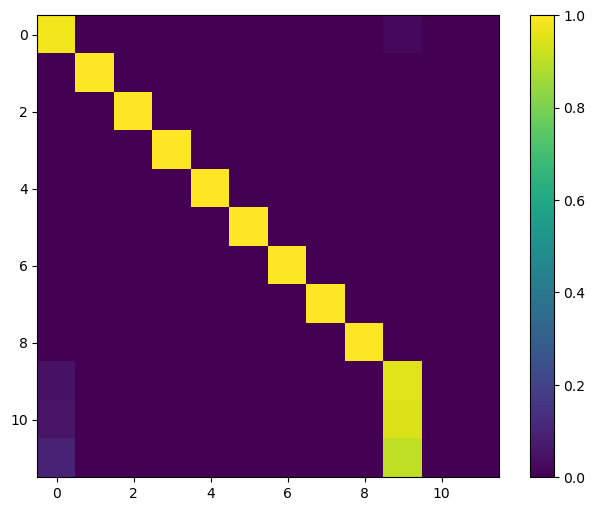

In [310]:
from torch.nn.functional import softmax

# Compute scores
scores = (queries @ keys.T)/np.sqrt(512)

# Instead of adding -inf, we set the scores to -inf where the mask is 0 -> Same thing ;)
scores.masked_fill_(~mask.bool(), -torch.inf)

# Apply softmax to scores
scores = softmax(scores, dim=-1)

# Print scores
scores = scores.detach().numpy()
util.plot_attention_scores(scores)

Perfect, the scores are concentrated to the left side!
For the causal mask (the lower triangle mask) we have to combine it with the decoder mask. We can do this by simply multiplying the two together!  

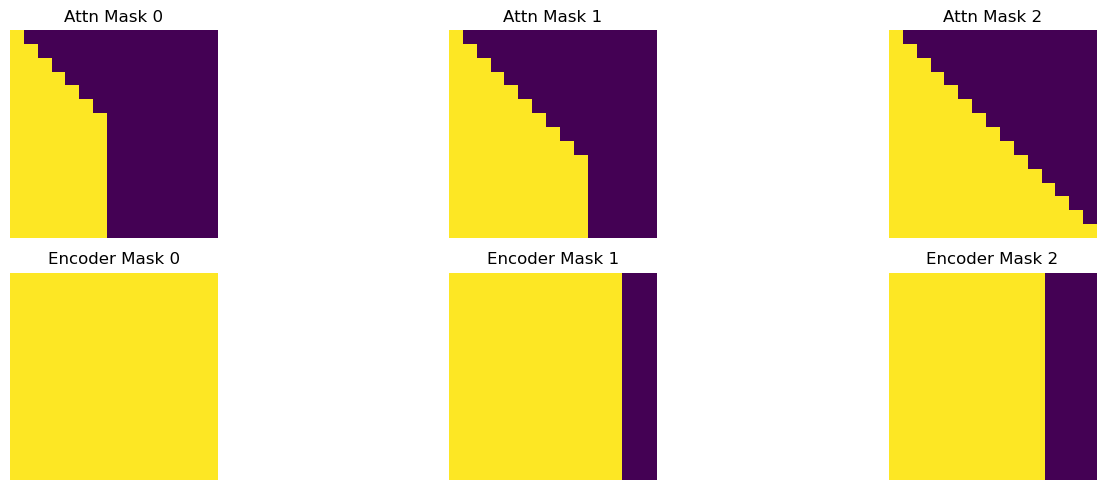

In [312]:
from exercise_code.util.transformer_util import create_causal_mask

# Get the masks from the first batch
encoder_mask = batch['encoder_mask']
decoder_mask = batch['decoder_mask']

# Create the causal mask (lower triangle mask) for the encoder
causal_mask = create_causal_mask(decoder_mask.shape[-1])

# Combine the decoder mask and the causal mask
causal_mask = causal_mask * decoder_mask

# Plot all masks
util.plot_boolean_masks(causal_mask, encoder_mask)

Note: For those who are wondering why the shape dont match up: The decoder mask and encoder mask dont have to be the same length for each sentence ;)

<div class="alert alert-info">
    <h3>Task 10: Implement</h3>
    <p>Add the padding masks at the appropriate spots in the code! Please go over the <code>forward()</code> passes in the <code>EncoderBlock</code>, <code>DecoderBlock</code> as well as the <code>Transformer</code> class in their respective files!
    </p>
</div>

In [315]:
_ = test_task_10()


####### Testing Started #######

Test TransformerPaddingTest: passed!

####### Testing Finished #######
Test TestTask10: passed! -->  Tests passed: 1/1
Score: 100/100


# Regularization

 We employ two types of regularization during training:
 
- Residual Dropout: 
We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of $P_{drop}$ = 0.1.
 
- Label Smoothing: 
During training, we employed label smoothing of value $\epsilon_{ls}$ = 0.1. This hurts perplexity, as the model learns to be more unsure, but improves accuracy. This means, that instead of using labels with one-hot encoding:

$ y_{1hot} = \begin{bmatrix}0 & 0 & 0 & \cdots & 1 & \cdots & 0 & 0 \end{bmatrix} $

Instead of zeros we use a small value $s = \frac{\epsilon_{ls}}{n_{cls} - 1}$, where $n_{cls}$ is the number of classes (=vocab_size). Since this has to be a proper distribution this has to add up 1. This results in a probability of being the correct word $p = 1 - \epsilon_{ls}$

For $n_{cls} = 11$ and $\epsilon_ls = 0.1$, this would result in:

$ y_{smooth} = \begin{bmatrix}0.01 & 0.01 & 0.01 & 0.01 & 0.9 & 0.01 & 0.01 & 0.01 & 0.01 & 0.01 & 0.01 \end{bmatrix} $

<div class="alert alert-info">
    <h3>Task 11: Implement</h3>
    <p>Initialize dropout in the classes <code>Embedding</code>, <code>ScaledDotAttention</code>, <code>MultiHeadAttention</code> and <code>FeedForwardNeuralNetwork</code> in their respective files. Don't forget to add it in the <code>forward()</code> pass! 
    </p>
</div>

In [318]:
# If you get an Error about SCORE_SAVER - please just restart your kernel!
_ = test_task_11()


####### Testing Started #######

Test EmbeddingDropoutTest: passed!
Test AttentionDropoutTest: passed!
Test MultiHeadDropoutTest: passed!
Test FeedForwardNeuralNetworkDropoutTest: passed!

####### Testing Finished #######
Test TestTask11: passed! -->  Tests passed: 4/4
Score: 100/100


<div class="alert alert-info">
    <h3>Task 12: Check Code</h3>
    <p>Have a look at <code>SmoothCrossEntropy</code> in <code>exercise_code/network/loss.py</code>
    </p>
</div>

# Optimizer

The paper used the Adam optimizer with $\beta_1 = 0.9$, $\beta_2 = 0.98$ and $\epsilon = 10^{-9}$. </br>
They varied the learning rate over the course of training, according to the formula: 

$lrate = d_{model}^{-0.5} \cdot min(step\_num^{−0.5}, step\_num \cdot warmup\_steps^{−1.5})$

This corresponds to increasing the learning rate linearly for the first warmup_steps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used warmup_steps = 4000.

The setup could look something like this:

In [322]:
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import matplotlib.pyplot as plt
from exercise_code.data.tokenizer import load_pretrained_fast

tokenizer = load_pretrained_fast()
model = Transformer(vocab_size=len(tokenizer), eos_token_id=tokenizer.eos_token_id)

d_model = model.d_model
lr_start =d_model**-0.5
eps=1e-9
betas=(0.9, 0.98)

optimizer = Adam(model.parameters(), lr=lr_start, eps=eps, betas=betas)

warm_up = 4000
lr_lambda=lambda step: min((step+1)**-0.5, (step+1)*warm_up**-1.5)
scheduler_example = LambdaLR(optimizer, lr_lambda=lr_lambda)

Let's have a look at this scheduler function

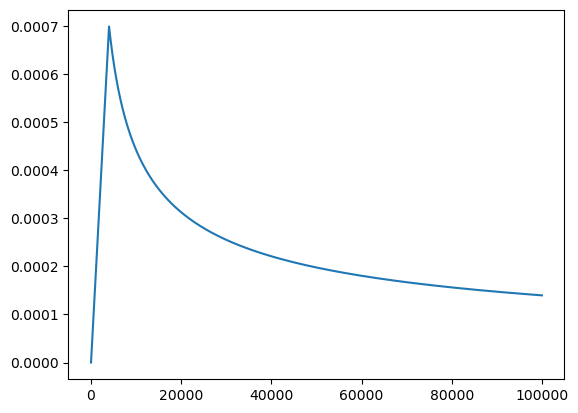

In [324]:
steps = np.arange(0, 100000)
lr = lr_start * np.vectorize(lr_lambda)(steps)

plt.plot(steps, lr)
plt.show()

# Training

Like already mentioned - Training is really where Transformers show there advantages compared to other sequential models! We can use a technique called **Teacher Forcing**, which means we feed the model the correct sentence, and the model only has to predict the next word! This is super easy to do in Transformers due to the causal masks we discussed earlier! In fact, all we have to do is pass the entire correct sentence into the decoder, and let it run exactly one time. The masking will make sure, each predicted word only depends on the previous words - no need to loop!

For this exercise, we will not train a large model on a huge dataset, this would simply take too long and also isn't the focus of this exercise! However, you will have to implement the parts of the Trainer class, particular the forward pass! Note that have implemented a couple of extra functionalities, such as training from a checkpoint and a gradient accumulation. Gradient accumulation is used, to decouple the batch size from the optimizing step. Instead of performing an update after every batch, we can update our network after n batches. That way, we can choose a smaller batch size to save RAM, and still have the same effects as we would have with a larger batch! Be aware, that this doesn't work as nicely with batch normalization!

<div class="alert alert-info">
    <h3>Task 13: Implement</h3>
    <p>Implement the <code>_forward()</code> method in the Trainer class in <code>exercise_code/trainer.py</code>
    </p>
</div>

Now we will overfit a small model on a dummy Dataset with small model.

In [328]:
import transformers
print(transformers.__version__)


4.48.0


In [329]:
from exercise_code.trainer import Trainer
from exercise_code.network import SmoothCrossEntropyLoss
from transformers import GPT2TokenizerFast
from exercise_code.network import Transformer

tokenizer = None

########################################################################
# TODO:                                                                #
#   Initialize your tokenizer. You train your own tokenizer and load   #
#   load it like we did in the first notebook, or load the pretrained  #
#   version!                                                           #
#                                                                      #
# Hint: Scroll up a couple of cells for the default tokenizer          #
########################################################################

# 初始化 Tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")


########################################################################
#                           END OF YOUR CODE                           #
########################################################################

hparams = None

########################################################################
# TODO:                                                                #
#   Implement you model here                                           #
#                                                                      #
########################################################################

hparams = {
    "d_model": 64,
    "d_ff": 256,
    "n_heads": 4,
    "n": 2,
    "dropout": 0.1,
    "max_length": 256,
}
pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
model = Transformer(vocab_size=len(tokenizer), 
                    eos_token_id=tokenizer.eos_token_id,
                    hparams=hparams)

Alright, let's check the model size! For this task, the model should have less than 5 million parameters.

In [331]:
_ = test_model_parameters(model)

Your model has 3743296 parameters.
Test TestModelParameters: passed!
Score: 100/100


Alright, now we can define the dataset and the dataloader. The dataset only contains 1000 lines. We will also initialize the Trainer:

In [333]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
optimizer = None
scheduler = None

epochs = None
batch_size = None

########################################################################
# TODO:                                                                #
#   Define the optimizer and optionally scheduler - not really needed  #
#                                                                      #
########################################################################

# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)
# 定义学习率调度器
def lr_lambda(step):
    warmup_steps = 1000
    if step < warmup_steps:
        return step / warmup_steps
    return (step / warmup_steps) ** -0.5

scheduler = LambdaLR(optimizer, lr_lambda)

# 定义超参数
batch_size = 32
epochs = 10

tokenizer.pad_token = tokenizer.eos_token
########################################################################
#                           END OF YOUR CODE                           #
########################################################################

loss_func = SmoothCrossEntropyLoss(smoothing=0.1)
file_path = os.path.join(dataset_path, 'dummyDatasets', 'ds_dummy')
collator = CustomCollator(tokenizer=tokenizer)
dataset = CustomIterableDataset(file_path)
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator)

# For Apple M1/M2/M3 users: Try out the MPS framework, it will significantly speed up your training!
if torch.cuda.is_available():
    device = torch.device("cuda")
elif MPS_AVAILABLE:
    if torch.backends.mps.is_available(): 
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

trainer = Trainer(model=model,
                  loss_func=loss_func,
                  train_loader=dataloader,
                  val_loader=None,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  epochs=epochs,
                  device=device,
                  optimizer_interval=0, # If you want to enable gradient accumulation, you can set this parameter! 
                  checkpoint_interval=0) # If you want to store your progress. You can resume training using train_from_checkpoint(#folder_number)
#print("Input shape:", inputs.shape)  # 模型输入
#print("Label shape:", labels.shape)  # 标签
#print("Mask shape:", label_mask.shape)   # 掩码

Now let's finally train the model! To pass this task, you will need at least 50% accuracy on the dataset! Note: Don't be surprised if this will take a few epochs (>50 probably) and the accuracy will get better very slowly, especially in the beginning! Just let it run, we are overfitting on purpose so it should usually always work at some point!

To explain the metrics: The first number is always the loss / accuracy over the current batch and the second number is always computed over the entire epoch.
You can also resume training by just executing the cell again. If you reached the end of your epochs and run it again, it will also continue, starting where you left of for as many epochs as you configured. If you stop this cell, your models parameters will not be altered - in other words if you see you have reached the accuracy, just stop the cell ;) 

In [335]:
trainer.train()

Training Epoch 1/10:   0%|                                                                 | 0/2 [00:00<?, ? batches/s]


RuntimeError: The size of tensor a (43) must match the size of tensor b (116) at non-singleton dimension 2

In [ ]:
_ = test_and_save_model(trainer, tokenizer, submission_path)

# Inference

The last part to do is test your model in inference! We will feed an input sentence into the algorithm, together with a maximum number of iterations. The sentence is then tokenized, so that we can feed it into the model. The first decoder input will only be the start token, which in our model is the same as the end token! The model will give us an output distribution over all tokens in our vocabulary. We can then either choose the token with the highest probability, or we can sample from this categorical distribution! That way, every answer will be slightly different! The last output is added to the decoder sequence and on it goes! If the model predicts an end token, we stop the algorithm. Otherwise we continue until the maximum number of iterations are reached! Finally, we can decode the output. This will look something like this:


Input Sentence: "Hi how are you" -> Tokenizer -> Encoder Input: [0, 45, 25, 15, 12, 0]

| Iteration  | Encoder Input          | Decoder Input                | Decoder Output                                   |
|------------|------------------------|------------------------------|--------------------------------------------------|
| 1          | [0, 45, 25, 15, 12, 0] | [0]                          | [445]                                            |
| 2          | [0, 45, 25, 15, 12, 0] | [0, 445]                     | [445, 56]                                        |
| 3          | [0, 45, 25, 15, 12, 0] | [0, 445, 56]                 | [445, 56, 89]                                    |
| 4          | [0, 45, 25, 15, 12, 0] | [0, 445, 56, 89]             | [445, 56, 89, 76]                                |
| 5          | [0, 45, 25, 15, 12, 0] | [0, 445, 56, 89, 76]         | [445, 56, 89, 76, 0]                             | -> 0 Detected!

Decoder Output: [445, 56, 89, 76, 0] -> Tokenizer -> Output Sentence: "Hallo wie geht's dir <[EOS]>"

<div class="alert alert-info">
    <h3>Task 14: Check Code</h3>
    <p>Have a look at the <code>predict()</code> method <code>Transformer</code> in <code>exercise_code/network/transformer.py</code>
    </p>
</div>

In [ ]:
def translate(input_sentence, max_iteration_length = 50, probabilistic = False, returns_scores = False):
    # Tokenize input sentence
    encoder_input = torch.tensor(tokenizer.encode(input_sentence))

    # Retrieve output sequence from model
    output_sequence, score_records = model.predict(encoder_input, max_iteration_length, probabilistic, returns_scores)

    # Decode output sequence
    output_sequence = tokenizer.decode(output_sequence, skip_special_tokens=True)
    
    if returns_scores:
        return output_sequence, score_records
    return output_sequence

Now you can test your model! Feel free to change the variable probabilistic to true! don't be to surprised, if the output is terrible at the moment though!

In [ ]:
# Let's just make sure the model is on the correct device
# Usually the Trainer does this, just in case you stopped training mid epoch!
_ = model.to("cpu")

In [ ]:
output_sequence = translate("Hi, how are you today?", probabilistic=False)
print(output_sequence)

Awesome, it works! 

Well, sort of - This sentece was part of the dataset! Let's try it with a different sentence:

In [ ]:
output_sequence = translate("This is not part of the dataset!", probabilistic=False)
print(output_sequence)

Well.. ups :D But remember, all we did is overfit to a small dataset with a small model!

We have prepared a pretrained model for you! It was trained on a larger dataset and has a lot more parameters! You should be able to load it as follows:

In [ ]:
tokenizer = load_pretrained_fast()

file_path = os.path.join(pretrained_model_path, 'pretrained_model')
load_dict = torch.load(file_path, weights_only=True)
model = Transformer(vocab_size=len(tokenizer),
                    eos_token_id=tokenizer.eos_token_id,
                    hparams=load_dict['hparams'])

model.load_state_dict(load_dict['model'])

Now try it again and see how it does:

In [ ]:
output_sequence = translate("This is not part of the dataset!", probabilistic=False)
print(output_sequence)

Alright, seems to work (Apart from a small typo, but we didn't train this model for that long)! Try out probabilistic to see some other results, they might be rubish though...

Note: If your model outputs something weird, you probably made some mistake a long the way that we didn't catch! Please go over your Encoder and Decoder Blocks and make sure you did this correctly! Especially look at the residual connections!

Congrats! You've now finished your first transformer model! Since this is a totally new exercise, we would really appreciate it if you could give us some [feedback](https://forms.gle/ZUZKcBiSY7bpsQko9)! Like which explanations did you like or not like, what was to hard and maybe what was to easy! 

To create a zip file with your submission, run the following cell:

In [ ]:
from exercise_code.util.submit import submit_exercise

path = os.path.join(root_path, 'output', 'exercise12')
submit_exercise(path)

# Submission Instructions

To complete the exercise, submit your final model to our submission portal - you probably know the procedure by now.

1. Go on [our submission page](https://i2dl.cvg.cit.tum.de/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an ID which we need in the next step.
2. Log into [our submission page](https://i2dl.cvg.cit.tum.de/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted file selectable on the top.
3. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Successfully implement a transformer model!

- Points:
    - 5 points per Module if shape is correct (FeedForwardNeuralNetwork, EncoderBlock, DecoderBlock, Transformer)
    - 5 points per Module if output is correct (FeedForwardNeuralNetwork, EncoderBlock, DecoderBlock, Transformer)
    - 30 points if submitted model reaches minimum score
    - Total = 4 x 5 + 4 x 5 + 30 = 70

- Passing Criteria: Minimum of 65 points!
- Feel free to submit an unlimited number of assignments until the end of the semester; however, any submissions made after the deadline will not contribute to your bonus points.
 